In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
from datetime import datetime

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from torch.autograd import Variable

import torch.nn as nn
import torch
import torch.nn.functional as F

from CanonicalComponentCCA import CanonicalComponent
from WitnessFunction import WitnessFunction
from Generate_synthetic import GenerateData
from sklearn.manifold import TSNE
from torch.utils.data.dataset import Dataset
from hsicv2 import hsic_gam_torch as hsic

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

In [4]:
from types import SimpleNamespace
opt = {
    "n_epochs": 100,
    "batch_size": 1000,
    "alpha": 0.009,
    "beta": 8e-5,
    "latent_dim": 1,
    "n_critic": 1,
    "lsmooth": 1
}
opt = SimpleNamespace(**opt)

In [5]:
visualize_dim = 5000

In [6]:
def run_simulations(signal_property, noise_property, data_dimensions, anchor_nums=0):
    #Generate data
    random_seed = 7
    torch.manual_seed(random_seed)
    
    # lambdaa = 0.1  #1.2, 0.05, 1e-2 for old f_theta
    
    cuda = True if torch.cuda.is_available() else False
    Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
    
    data_generate = GenerateData(data_dimensions, opt.batch_size)
    
    mixer_property = {"mean": 0, "std": 1, "dist": "normal"}
    X_1, X_2, S, scir, C1, C2 = data_generate.generate_cca_data(signal_property, noise_property, mixer_property, normalize_mean=True, diff_mixture=True)
    
    if data_dimensions["D"] >= 3:
        display_type = 3
    else:
        display_type = data_dimensions["D"]
    
    A1, A2 = data_generate.get_mixing_matrices()
    A1 = A1.type(Tensor)
    A2 = A2.type(Tensor)
    print("Conditions number of mixing matrices: ", torch.linalg.cond(A1), torch.linalg.cond(A2))
    
    X_1 = Variable(X_1.type(Tensor))
    X_2 = Variable(X_2.type(Tensor))
    S = Variable(S.type(Tensor))

    if anchor_nums>0:
        print("Multiple anchor points")
        random_indices = np.random.choice(X_1.shape[1], size=anchor_nums, replace=False)
        anchors1 = X_1[:, random_indices]
        anchors2 = X_2[:, random_indices]
    else:
        anc_loss = torch.tensor([0.0]).type(Tensor)
        anchors1 = []
        anchors2 = []
    
    view1, view2 = data_generate.create_dataloader(X_1, X_2)
    
    z1 = CanonicalComponent(X_1, data_dimensions["D"], data_dimensions["M1"], data_dimensions["N"], Tensor)
    z2 = CanonicalComponent(X_2, data_dimensions["D"], data_dimensions["M2"], data_dimensions["N"], Tensor)
    f = WitnessFunction(data_dimensions["D"], opt.latent_dim)

    z1_p = CanonicalComponent(X_1, data_dimensions["D1"], data_dimensions["M1"], data_dimensions["N"], Tensor)
    z2_p = CanonicalComponent(X_2, data_dimensions["D2"], data_dimensions["M2"], data_dimensions["N"], Tensor)
    
    
    if cuda:
        z1.cuda()
        z2.cuda()
        f.cuda()
        z1_p.cuda()
        z2_p.cuda()
    
    # Optimizers
    alpha1 = opt.alpha
    alpha2 = opt.alpha
    beta = opt.beta
    optimizer_z1 = torch.optim.Adam(z1.parameters(), lr=alpha1)
    optimizer_z2 = torch.optim.Adam(z2.parameters(), lr=alpha1)
    optimizer_f = torch.optim.Adam(f.parameters(), lr=beta)

    optimizer_z1_p = torch.optim.Adam(z1_p.parameters(), lr=1e-3)
    optimizer_z2_p = torch.optim.Adam(z2_p.parameters(), lr=1e-3)
    
    lambdaa = 0.1  #1.2, 0.05, 1e-2 for old f_theta
    lambdaa_p = 10.0
    lambda_anc = 0.01
    lambda_hsic = 50.0
    # lambda_recon = 0.0
    
    n_epochs = data_dimensions["n_epochs"]
    batch_size = opt.batch_size
    lsmooth = 1
    loss_func = nn.BCELoss()
    
    n_critic = 1
    n_z1 = 1
    n_z2 = 1
    
    
    D = data_dimensions["D"]
    
    all_loss_f = []
    all_loss_z = []
    shared_component_dist = []
    for epoch in range(n_epochs-1):
        
        noise_factor = 1.0 - (epoch / n_epochs)
        avg_loss_z = []
        avg_loss_f = []
        avg_shared_dist = []
        for i, (X1, X2) in enumerate(zip(view1, view2)):
            
            ############################Distribution matching ################################
            labels_true = (torch.ones((batch_size, 1) )  - lsmooth * (torch.rand((batch_size, 1)) * 0.2 * noise_factor) ).type(Tensor) 
            labels_false = (torch.zeros((batch_size, 1) ) + lsmooth * (torch.rand((batch_size, 1) ) * 0.2 * noise_factor) ).type(Tensor)
    
            for _ in range(n_critic):
                # ---------------------
                #  Train Discriminator
                # ---------------------
                optimizer_f.zero_grad()
    
                # Select one generator to update
                s_1 = z1(X1).T
                s_2 = z2(X2).T
    
                # Discriminator loss
                loss_f = loss_func(f(s_1), labels_true) + loss_func(f(s_2), labels_false)
    
                loss_f.backward()
                optimizer_f.step()
    
             #######################################################################################
            for _ in range(n_z1):
                optimizer_z1.zero_grad()
                optimizer_z2.zero_grad()
                
                s_1 = z1(X1).T
                s_2 = z2(X2).T
    
                loss_fz1 = loss_func(f(s_1), labels_false)
                reg_z1 =   D * z1.id_loss()
                loss_fz2 = loss_func(f(s_2), labels_true)
                reg_z2 =   D*z2.id_loss()
                
                if anchor_nums > 0:
                    anc_loss = torch.norm(z1(anchors1.T) - z2(anchors2.T))**2
                loss_z1 = loss_fz1 + loss_fz2 + lambdaa * reg_z1+ lambdaa * reg_z2 + lambda_anc * anc_loss
                
                loss_z1.backward()
                optimizer_z1.step()
                optimizer_z2.step()
            

            #Private training
            optimizer_z1_p.zero_grad()
            optimizer_z2_p.zero_grad()

            s_1 = z1(X1).T
            s_2 = z2(X2).T

            p_1 = z1_p(X1).T
            p_2 = z2_p(X2).T
            
            reg_p1 =   data_dimensions["D1"] * z1_p.id_loss()
            reg_p2 =   data_dimensions["D2"] * z2_p.id_loss()

            hsic_loss1 = hsic(s_1, p_1)
            hsic_loss2 = hsic(s_2, p_2)
            
            hsic_loss = lambda_hsic * hsic_loss1 + lambda_hsic * hsic_loss2
            total_private_loss = hsic_loss + lambdaa_p * reg_p1 + lambdaa_p * reg_p2
            
            total_private_loss.backward()
            
            optimizer_z1_p.step()
            optimizer_z2_p.step()
            # optimizer_a.step()
            
            with torch.no_grad():
                loss_z = loss_fz1 + loss_fz2
                loss_reg = (reg_z1 + reg_z2)/D
                loss_reg_private = (reg_p1/data_dimensions["D1"]) + (reg_p2/data_dimensions["D2"])
                
                s_x = z1(X_1.T).T
                s_y = z2(X_2.T).T
                dist_loss = torch.norm(s_x-s_y)
                    
                
            avg_loss_f.append( loss_f.item() )
            avg_loss_z.append( loss_z.item() )
            avg_shared_dist.append( dist_loss.item() )
            print(
                "[Epoch %d of %d]  [z1: %f] [z2: %f] [z: %f] [f: %f] [anc: %f] [reg c : %f] [h1 : %f] [h2 : %f] [rp : %f] [%f]" 
                % (epoch+1, i+1, loss_fz1.item(), loss_fz2.item(), loss_z.item(), loss_f.item(), anc_loss.item(), loss_reg.item(),
                   hsic_loss1.item(), hsic_loss2.item(), loss_reg_private, dist_loss.item() )
            )
                
        
        all_loss_f.append(np.mean(avg_loss_f))
        all_loss_z.append(np.mean(avg_loss_z))
        shared_component_dist.append(np.mean(avg_shared_dist))
    return S, C1, C2, z1, z2, A1, A2, X_1, X_2, z1_p, z2_p, shared_component_dist

In [7]:
def find_plots(metadata):
    
    S, C1, C2, z1, z2, A1, A2, X_1, X_2, z1_p, z2_p, _ = metadata
    
    D = S.shape[0]
    
    q1 = z1.get_Q_value()
    q2 = z2.get_Q_value()
    theta_1 = (q1 @ A1).detach().cpu()
    theta_2 = (q2 @ A2).detach().cpu()

    q1_p = z1_p.get_Q_value()
    q2_p = z2_p.get_Q_value()
    theta_1_p = (q1_p @ A1).detach().cpu()
    theta_2_p = (q2_p @ A2).detach().cpu()

    print("Theta 1: ", theta_1)
    print("Theta 2: ", theta_2)

    print("Theta 1 private: ", theta_1_p)
    print("Theta 2 private: ", theta_2_p)
    
    if D > 2:
        print("Applying TSNE to shared components. Dimension greater than 2.")
        s_x = z1(X_1.T).T.detach()
        s_y = z2(X_2.T).T.detach()
        
        corig = S[:,:visualize_dim].T.cpu().numpy()
        c1 = s_x[:visualize_dim,].cpu().numpy()
        c2 = s_y[:visualize_dim,].cpu().numpy()

        tsne_shared = TSNE(n_components=2)
        tsne_c = tsne_shared.fit_transform(np.vstack( (corig,  c1, c2)  ))
        corig = tsne_c[:visualize_dim, ].T
        c1 = tsne_c[visualize_dim: 2*visualize_dim, ].T
        c2 = tsne_c[2*visualize_dim:, ].T
        
        print("Finished TSNE for shared components.")
        
        
    else:
        s_x = z1(X_1.T).T.detach()
        s_y = z2(X_2.T).T.detach()
        
        corig = S[:,:visualize_dim].cpu().numpy()
        c1 = s_x[:visualize_dim,].T.cpu().numpy()
        c2 = s_y[:visualize_dim,].T.cpu().numpy()

    p1 = z1_p(X_1.T).detach().cpu().numpy()[:,:visualize_dim]
    p2 = z2_p(X_2.T).detach().cpu().numpy()[:,:visualize_dim]
    p1_orig = C1[:,:visualize_dim].cpu().numpy()
    p2_orig = C2[:,:visualize_dim].cpu().numpy()

    tsne = TSNE(n_components=2)
    tsne_l = tsne.fit_transform(np.vstack( (X_1.T[:visualize_dim,].cpu().numpy(), X_2.T[:visualize_dim,].cpu().numpy()) ) )
    domain1 = tsne_l[:visualize_dim, ].T
    domain2 = tsne_l[visualize_dim:, ].T
    print("Finished applying TSNE")

    

    return corig, c1, c2, p1, p2, p1_orig, p2_orig, domain1, domain2

# Theorem 6 validations

In [8]:
#Dimensions intializations M_q>=D, M_q >= (D+D1)cca_loss
data_dimensions = {
    "N": 10**5, #Number of samples
    "D": 2, #shared component vector length
    "D1": 1, #Private component 1 vector length
    "D2": 1, #Private component 2 vector length
    "M1": 3, #(Number of rows)/(length of data) in actual data view1/ mixing matrix
    "M2": 3, #(Number of rows)/(length of data) in actual data view2/ mixing matrix
    "n_epochs":50
}

## Private component extraction

In [ ]:
signal_property = {"mean": 2.5, "std": 2, "dist": "vonmises"} #these are parameters instead of mean and variance even though the variable is so
noise_property = {"mean1": 1, "std1":3, "mean2": 0.5, "std2": 3, "dist1": "beta", "dist2": "gamma"}
 
metadata = run_simulations(signal_property, noise_property, data_dimensions)
corig, c1, c2, p1, p2, p1_orig, p2_orig, domain1, domain2 = find_plots(metadata)

Generating mixing  matrix.
Shared Component to Interference Ratio: -0.739
Conditions number of mixing matrices:  tensor(5.0000, device='cuda:0') tensor(5.0000, device='cuda:0')
[Epoch 1 of 1]  [z1: 0.749868] [z2: 0.649218] [z: 1.399086] [f: 1.394400] [anc: 0.000000] [reg c : 671.301758] [h1 : 43.293873] [h2 : 57.892605] [rp : 323.664856] [7826.063477]
[Epoch 1 of 2]  [z1: 0.748428] [z2: 0.657506] [z: 1.405933] [f: 1.382900] [anc: 0.000000] [reg c : 660.330383] [h1 : 43.179447] [h2 : 56.524010] [rp : 323.138977] [7762.188477]
[Epoch 1 of 3]  [z1: 0.747507] [z2: 0.666856] [z: 1.414362] [f: 1.376327] [anc: 0.000000] [reg c : 649.472534] [h1 : 46.110085] [h2 : 57.189415] [rp : 322.614685] [7698.511719]
[Epoch 1 of 4]  [z1: 0.746005] [z2: 0.677800] [z: 1.423805] [f: 1.370375] [anc: 0.000000] [reg c : 638.730042] [h1 : 40.259533] [h2 : 57.324261] [rp : 322.084473] [7635.047363]
[Epoch 1 of 5]  [z1: 0.746239] [z2: 0.705307] [z: 1.451547] [f: 1.357631] [anc: 0.000000] [reg c : 628.105042] [h1 

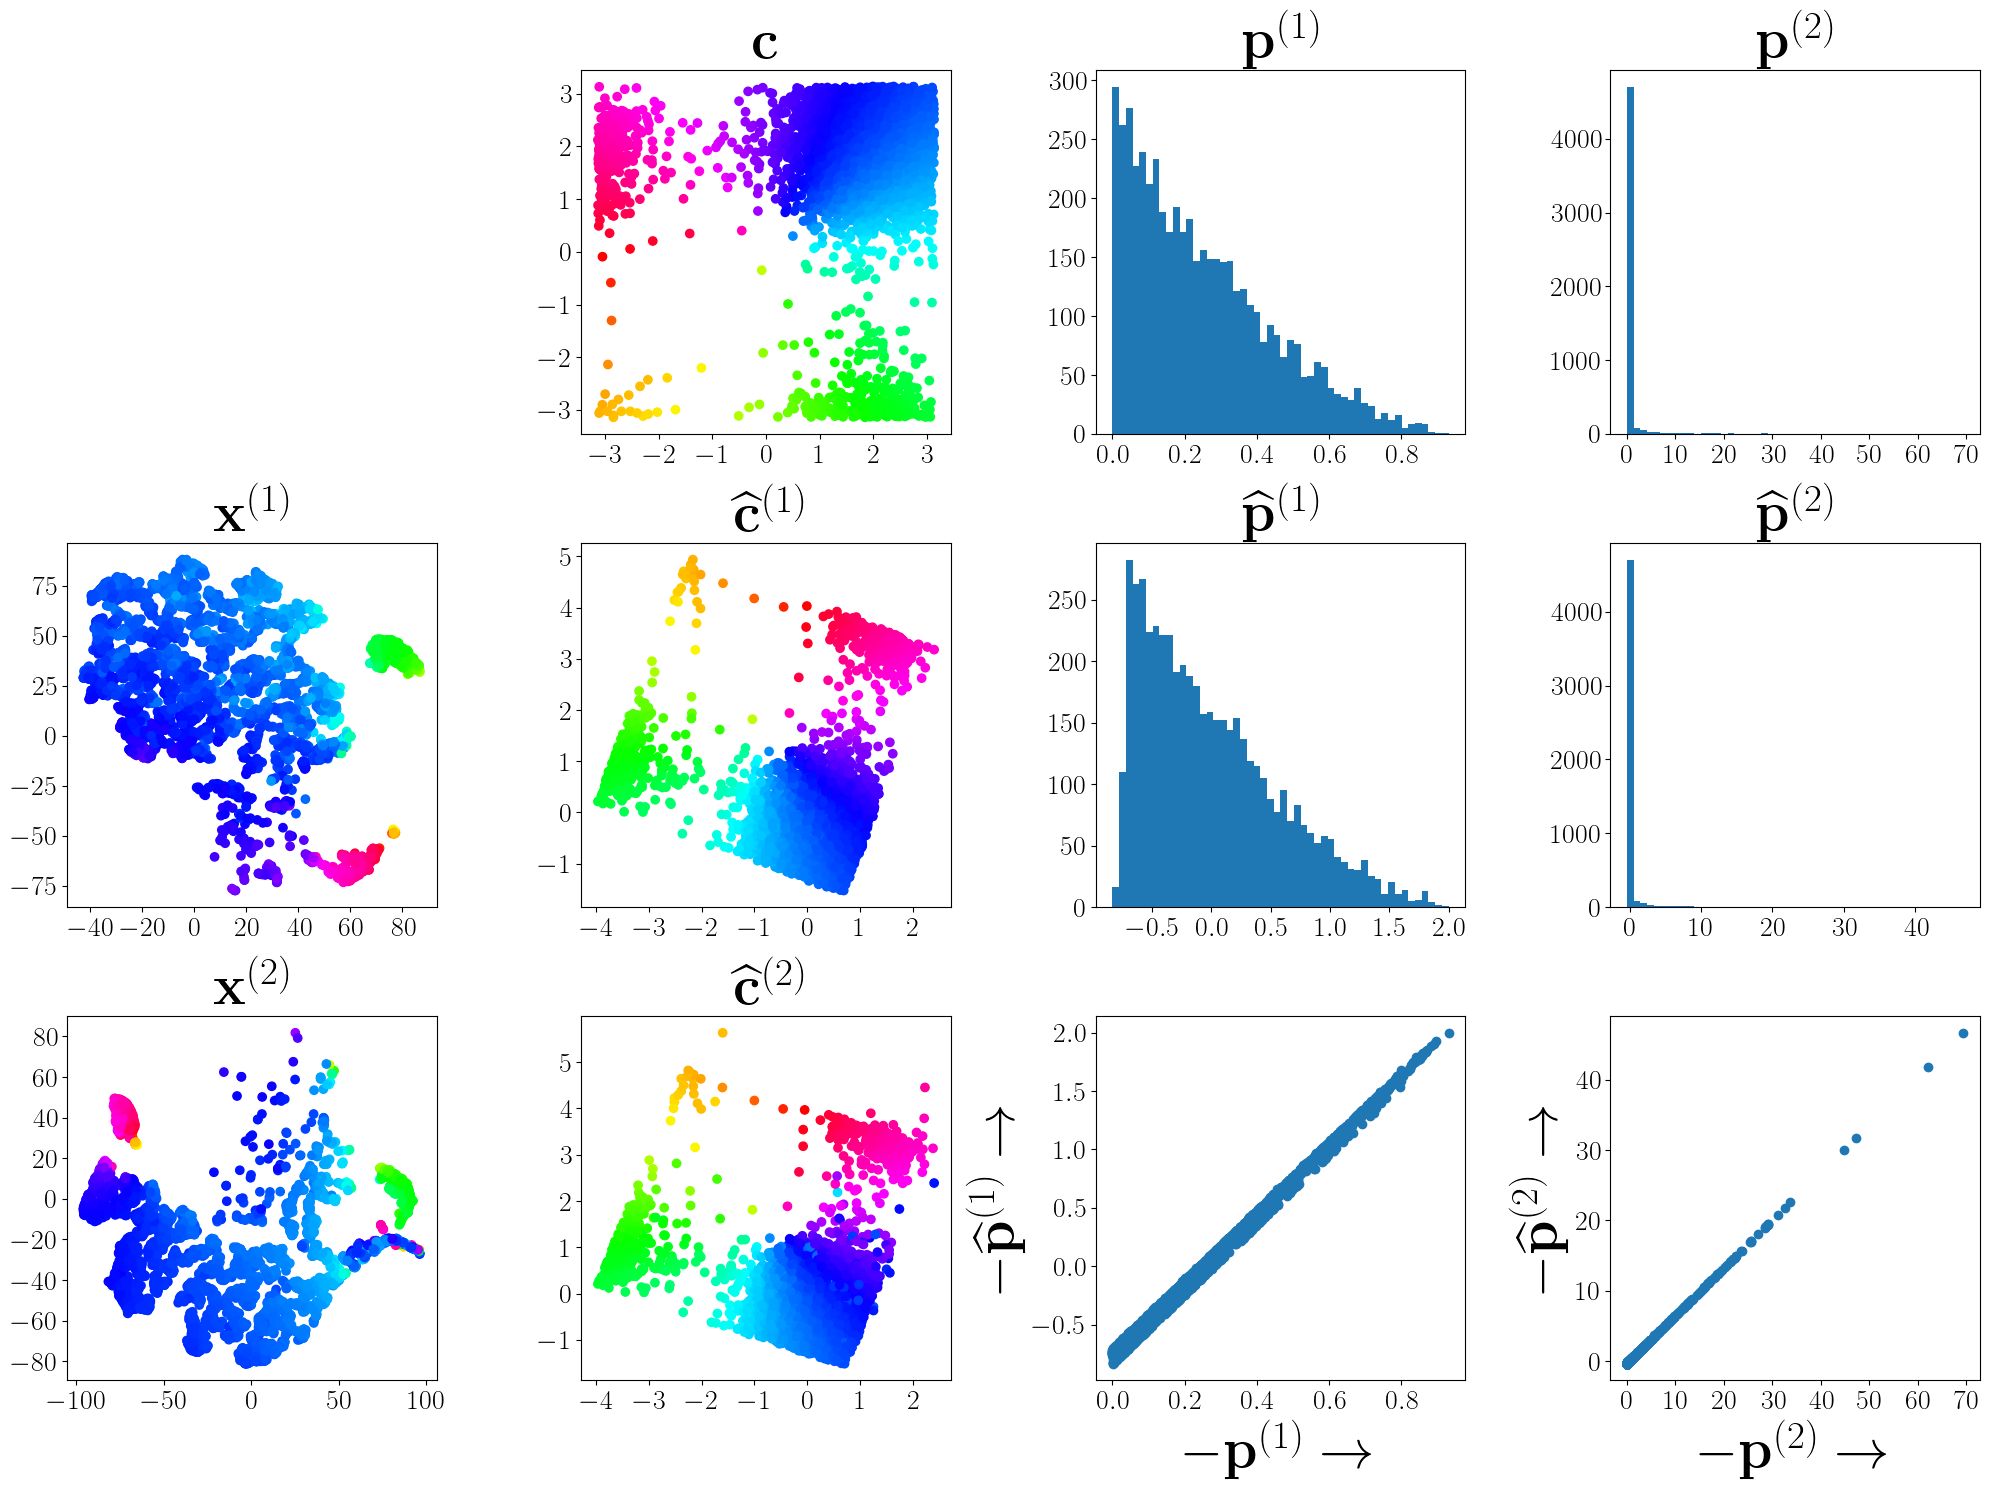

In [11]:
dims = [0, 1]
f1size = 20
f2size = 40
f3size = 30
label_color = "black"

plt.close('all')
plt.figure(figsize=(20, 15))

colors = np.arctan2(corig[dims[1]], corig[dims[0]])
# plt.subplot(3, 4, 1)
# x = np.linspace(0, 1, 100)
# y = -x
# plt.plot(x, y, '-', color='black', linewidth=5)
# plt.text(0.5, -0.5, 'Ground truth latent', fontsize=f1size, ha='center')
# plt.xticks([])
# plt.yticks([])


plt.subplot(3, 4, 2)
plt.title(r"$\mathbf{c}$", fontsize=f2size)
plt.scatter(corig[dims[0]], corig[dims[1]], c=colors, cmap='hsv')
plt.xticks(fontsize=f1size)
plt.yticks(fontsize=f1size)

plt.subplot(3, 4, 3)
plt.title(r"$\mathbf{p}^{(1)}$", fontsize=f2size)
plt.hist(p1_orig.T, bins=50)
plt.xticks(fontsize=f1size)
plt.yticks(fontsize=f1size)

plt.subplot(3, 4, 4)
plt.title(r"$\mathbf{p}^{(2)}$", fontsize=f2size)
plt.hist(p2_orig.T, bins=50)
plt.xticks(fontsize=f1size)
plt.yticks(fontsize=f1size)


###

plt.subplot(3, 4, 5)
plt.title(r"$\mathbf{x}^{(1)}$", fontsize=f2size)
plt.scatter(domain1[dims[0]], domain1[dims[1]], c=colors, cmap='hsv')
plt.xticks(fontsize=f1size)
plt.yticks(fontsize=f1size)

plt.subplot(3, 4, 6)
plt.title(r"$\widehat{\mathbf{c}}^{(1)}$", fontsize=f2size)
plt.scatter(c1[dims[0]], c1[dims[1]], c=colors, cmap='hsv')
plt.xticks(fontsize=f1size)
plt.yticks(fontsize=f1size)

plt.subplot(3, 4, 7)
plt.title(r"$\widehat{\mathbf{p}}^{(1)}$", fontsize=f2size)
plt.hist(p1.T, bins=50)
plt.xticks(fontsize=f1size)
plt.yticks(fontsize=f1size)

plt.subplot(3, 4, 8)
plt.title(r"$\widehat{\mathbf{p}}^{(2)}$", fontsize=f2size)
plt.hist(p2.T, bins=50)
plt.xticks(fontsize=f1size)
plt.yticks(fontsize=f1size)

####
plt.subplot(3, 4, 9)
plt.title(r"$\mathbf{x}^{(2)}$", fontsize=f2size)
plt.scatter(domain2[dims[0]], domain2[dims[1]], c=colors, cmap='hsv')
plt.xticks(fontsize=f1size)
plt.yticks(fontsize=f1size)

plt.subplot(3, 4, 10)
plt.title(r"$\widehat{\mathbf{c}}^{(2)}$", fontsize=f2size)
plt.scatter(c2[dims[0]], c2[dims[1]], c=colors, cmap='hsv')
plt.xticks(fontsize=f1size)
plt.yticks(fontsize=f1size)

plt.subplot(3, 4, 11)
plt.xlabel(r"$-\mathbf{p}^{(1)}\rightarrow$", fontsize=f2size, color=label_color)
plt.ylabel(r"$-\widehat{\mathbf{p}}^{(1)}\rightarrow$", fontsize=f2size, color=label_color)
plt.scatter(p1_orig[0], p1[0])
plt.xticks(fontsize=f1size)
plt.yticks(fontsize=f1size)

plt.subplot(3, 4, 12)
plt.xlabel(r"$-\mathbf{p}^{(2)}\rightarrow$", fontsize=f2size, color=label_color)
plt.ylabel(r"$-\widehat{\mathbf{p}}^{(2)}\rightarrow$", fontsize=f2size, color=label_color)
plt.scatter(p2_orig[0], p2[0])
plt.xticks(fontsize=f1size)
plt.yticks(fontsize=f1size)




plt.tight_layout()
# plt.savefig("theorem6_result.pdf", dpi=100, bbox_inches='tight', format='pdf')